# Testbed Delay Asymmetry Tests

Steps to reproduce:

1. Run the BBU build from pipeline 1101:
```
./prog.py -p 1101 bbu
```

2. Run the RRU build from pipeline 1096:
```
./prog.py -p 1096 -r 1 rru 
```

3. Open minicom to both BBU and RRU. Wait for the RRU to lock on sync stage 3.

4. Disable FH traffic traffic on both sides (BBU and RRU). Send `command 9` over UART to both devices and check that their occupancies really become 0.

5. Run the acquisition. Collect 1000 samples from each hop configuration. Set the number of hops correctly in order to save this information on the metadata section of the dataset:
```
./capture.py -vvvv --hops 1 -N 1000
```

6. Prepare to acquire another dataset, for another hop count. Restart the FW on both devices and go back to step #3.
```
./prog.py -p 1101 -e bbu
```
```
./prog.py -p 1096 -r 1 -e rru 
```

When done, move all dataset files to `/opt/timestamps_logs/asymmetry_test`. Put it in a folder called `run_i`, where `i` is to index the number of repetitions of the experiment.

## Analysis

In [12]:
import sys, os
sys.path.append(os.path.abspath('../'))
import ptp.reader
import ptp.metrics
import ptp.frequency
import ptp.window
%matplotlib inline
import numpy as np

## Asymmetry Assessment


Dataset:        serial-20190809-182547.json
Number of hops: 1


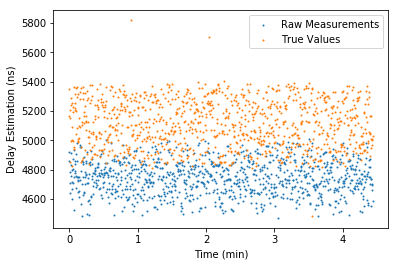

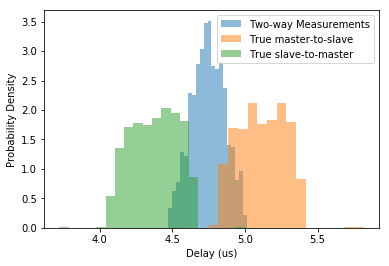

Mean d_fw: 5116.301000	Std d_fw: 158.426906
Mean d_bw: 4375.419000	Std d_bw: 160.934966
Mean asym: 740.882000

Dataset:        serial-20190809-183403.json
Number of hops: 2


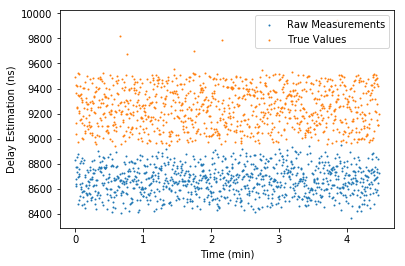

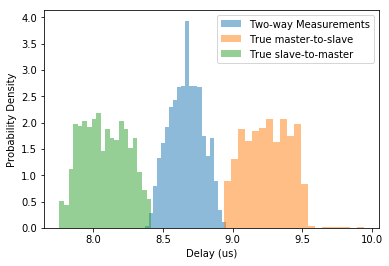

Mean d_fw: 9252.085000	Std d_fw: 161.176983
Mean d_bw: 8081.076000	Std d_bw: 160.213009
Mean asym: 1171.009000

Dataset:        serial-20190809-184332.json
Number of hops: 3


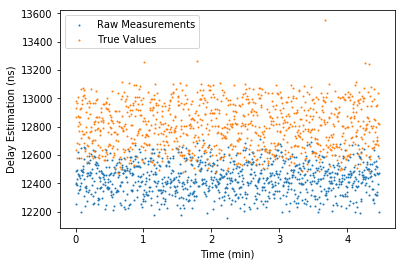

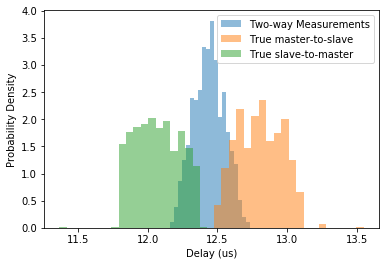

Mean d_fw: 12805.547000	Std d_fw: 161.007844
Mean d_bw: 12069.619000	Std d_bw: 159.372400
Mean asym: 735.928000

Dataset:        serial-20190809-185354.json
Number of hops: 4


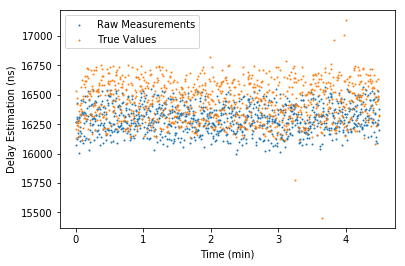

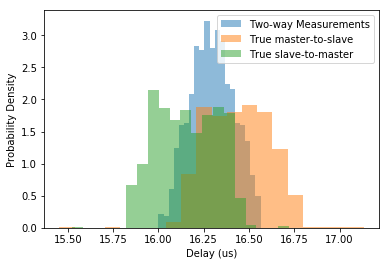

Mean d_fw: 16440.245000	Std d_fw: 171.295251
Mean d_bw: 16156.096000	Std d_bw: 168.348468
Mean asym: 284.149000


In [14]:
filenames = ["../data/asymmetry_test/serial-20190809-182547.json",
             "../data/asymmetry_test/serial-20190809-183403.json",
             "../data/asymmetry_test/serial-20190809-184332.json",
             "../data/asymmetry_test/serial-20190809-185354.json"]

d_mean_fw_vec = np.zeros(len(filenames))
d_mean_bw_vec = np.zeros(len(filenames))
asym_mean_vec = np.zeros(len(filenames))

for idx, filename in enumerate(filenames):
    reader = ptp.reader.Reader(filename)
    reader.run()
    print("\n================================================================================")
    print("================================================================================")
    print("Dataset:        %s" %os.path.basename(filename))
    print("Number of hops: %d" %reader.metadata["hops"])

    analyser = ptp.metrics.Analyser(reader.data)
    analyser.plot_delay_vs_time(save=False)
    analyser.plot_delay_hist(save=False, n_bins=20)

    d_fw = np.array([r["d"] for r in reader.data]) 
    d_bw = np.array([r["d_bw"] for r in reader.data])

    print("Mean d_fw: %f\tStd d_fw: %f" %(np.mean(d_fw), np.std(d_fw)))
    print("Mean d_bw: %f\tStd d_bw: %f" %(np.mean(d_bw), np.std(d_bw)))
    print("Mean asym: %f" %(np.mean(d_fw - d_bw)))
    
    d_mean_fw_vec[idx] = np.mean(d_fw)
    d_mean_bw_vec[idx] = np.mean(d_bw)
    asym_mean_vec[idx] = np.mean(d_fw - d_bw)

## Delay/asymmetry incurred per hop

In [30]:
for i in range(1,len(filenames)):
    print("\nDifference from VLAN %d to %d" %(i, i+1))
    print("FW delay\tBW delay\tAsymmetry")
    print("%+f\t%+f\t%+f" %(
        d_mean_fw_vec[i] - d_mean_fw_vec[i-1],
        d_mean_bw_vec[i] - d_mean_bw_vec[i-1],
        asym_mean_vec[i] - asym_mean_vec[i-1]
    ))



Difference from VLAN 1 to 2
FW delay	BW delay	Asymmetry
+4135.784000	+3705.657000	+430.127000

Difference from VLAN 2 to 3
FW delay	BW delay	Asymmetry
+3553.462000	+3988.543000	-435.081000

Difference from VLAN 3 to 4
FW delay	BW delay	Asymmetry
+3634.698000	+4086.477000	-451.779000
